# Synthèse ML classification

## Préparations des données

In [1]:
import numpy as np
import pandas as pd

def import_data():
    x_train = pd.read_csv(r"Dataset\DBP\x_train.csv",index_col=False)
    y_train = pd.read_csv(r"Dataset\DBP\y_train.csv",index_col=False)
    x_test = pd.read_csv(r"Dataset\DBP\x_test.csv",index_col=False)
    y_test = pd.read_csv(r"Dataset\DBP\y_test.csv",index_col=False)
    
    x_train = x_train['text']
    y_train = y_train['l3']
    x_test = x_test['text']
    y_test = y_test['l3']

    print("Taille du dataset d'entrainnement :",x_train.shape[0])
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = import_data()

x_train = x_train.astype(str)
x_test = x_test.astype(str)


Taille du dataset d'entrainnement : 274224


## Préparation des modèles

### Modèle 1 (TF-IDF & MNB)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create Pipeline
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Set parameters to search
parameters_1 = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],               # unigrams ou unigrams + bigrams
    'tfidf__min_df': [1, 2, 3],                           # ignorer les termes trop rares
    'tfidf__max_df': [0.85, 0.95],                        # ignorer les termes trop fréquents
    'tfidf__use_idf': [True, False],                      # tester avec ou sans le facteur IDF
    'tfidf__smooth_idf': [True, False],                   # tester le lissage IDF
    'tfidf__sublinear_tf': [True, False],                 # logarithmiser le comptage
    'nb__alpha': [0.01, 0.1, 0.5, 1.0],
}

def create_pipeline(pipeline,parameters,dfx_train,dfy_train):
    model = HalvingGridSearchCV(
    pipeline,
    parameters,
    cv=3,
    factor=2,
    scoring='accuracy',
    error_score='raise',
    n_jobs=-1,
    verbose=1,
)
    try:
        model.fit(dfx_train, dfy_train)
        print("Best parameters found: ", model.best_params_)
        print("Best score: ", model.best_score_)
    except Exception as e:
        print("An error occurred: ", e)
    
    return model


model_1 = create_pipeline(pipeline_1,parameters_1,x_train,y_train)

n_iterations: 8
n_required_iterations: 9
n_possible_iterations: 8
min_resources_: 1314
max_resources_: 274224
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 384
n_resources: 1314
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
----------
iter: 1
n_candidates: 192
n_resources: 2628
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 2
n_candidates: 96
n_resources: 5256
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 3
n_candidates: 48
n_resources: 10512
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 4
n_candidates: 24
n_resources: 21024
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 5
n_candidates: 12
n_resources: 42048
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 6
n_candidates: 6
n_resources: 84096
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 7
n_candidates: 3

### Modèle 2 (TF-IDF & SVM)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convertit les textes en vecteurs
    ('classifier', LinearSVC())
])

parameters_2 = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],               # unigrams ou unigrams + bigrams
    'tfidf__min_df': [1, 2, 3],                           # ignorer les termes trop rares
    'tfidf__max_df': [0.85, 0.95],                        # ignorer les termes trop fréquents
    'tfidf__use_idf': [True, False],                      # tester avec ou sans le facteur IDF
    'tfidf__smooth_idf': [True, False],                   # tester le lissage IDF
    'tfidf__sublinear_tf': [True, False],  
    'classifier__C': np.linspace(0.1, 3, 5),
}

model_2 = create_pipeline(pipeline_2,parameters_2,x_train,y_train)

n_iterations: 8
n_required_iterations: 9
n_possible_iterations: 8
min_resources_: 1314
max_resources_: 274224
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 480
n_resources: 1314
Fitting 3 folds for each of 480 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 240
n_resources: 2628
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 2
n_candidates: 120
n_resources: 5256
Fitting 3 folds for each of 120 candidates, totalling 360 fits
----------
iter: 3
n_candidates: 60
n_resources: 10512
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 4
n_candidates: 30
n_resources: 21024
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 5
n_candidates: 15
n_resources: 42048
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 6
n_candidates: 8
n_resources: 84096
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 7
n_candidates:

### Modèle 3 (Word embedding & SVM)

#### Initialisation du Word embedding et vectorisation des données

In [2]:
from gensim.models import Word2Vec

vector_size = 300
window = 5
workers = 4

def create_W2V (df):
    W2V_model = Word2Vec(sentences=[doc.split() for doc in df], vector_size=vector_size, window=window, min_count=1, workers=workers)
    return W2V_model

def document_vector(df,model):
    docs=[doc.split() for doc in df]
    doc_embeddings = []
    for doc in docs:
        vectors = [model.wv[word] for word in doc if word in model.wv]
        if vectors:
            doc_embeddings.append(np.mean(vectors, axis=0))
        else:
            doc_embeddings.append(np.zeros(model.vector_size))
    
    return np.array(doc_embeddings)

model_W2V = create_W2V(x_train)
x_train_emb = document_vector(x_train,model_W2V )
x_test_emb = document_vector(x_test,model_W2V )



In [3]:
x_train_emb.shape, x_test_emb.shape

((274224, 300), (68557, 300))

#### Création du modèle

In [5]:
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

parameters = {
    'C': np.linspace(0.1, 1, 10)
}

def create_modelSVM(dfx_train, dfy_train):
    model = LinearSVC()
    grid_search = HalvingGridSearchCV(
    model,
    parameters,
    cv=3,
    factor=2,
    scoring='accuracy',
    error_score='raise',
    n_jobs=-1,
    verbose=1,
    )
    try:
        grid_search.fit(dfx_train, dfy_train)
        print("Best parameters found: ", grid_search.best_params_)
        print("Best score: ", grid_search.best_score_)
    except Exception as e:
        print("An error occurred: ", e)
    
    return grid_search

model_3 = create_modelSVM(x_train_emb,y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 34278
max_resources_: 274224
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 34278
Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

Justifier pourquoi j'ai pas inclut l'embedding dans le pipeline

## Comparaison des modèles


===== Évaluation de TF-IDF & MNB =====
Best parameters: {'nb__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
Best cross-validation score: 0.8810
Test accuracy: 0.8947
Classification Report:
                                   precision    recall  f1-score   support

                  AcademicJournal       0.89      0.95      0.92       523
                       AdultActor       0.94      0.85      0.89       240
                          Airline       0.99      0.96      0.97       561
                          Airport       0.98      0.95      0.97       555
                            Album       0.85      0.71      0.77       546
                     AmateurBoxer       0.98      0.86      0.92        70
                       Ambassador       0.87      0.62      0.73       109
           AmericanFootballPlayer       0.92      0.92      0.92       533
           

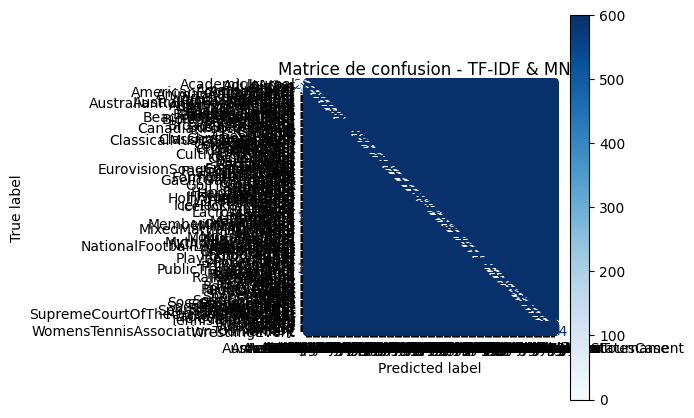


===== Évaluation de TF-IDF & SVM =====
Best parameters: {'classifier__C': 2.275, 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best cross-validation score: 0.9257
Test accuracy: 0.9349
Classification Report:
                                   precision    recall  f1-score   support

                  AcademicJournal       0.95      0.97      0.96       523
                       AdultActor       0.91      0.85      0.88       240
                          Airline       0.97      0.97      0.97       561
                          Airport       0.98      0.97      0.97       555
                            Album       0.92      0.89      0.90       546
                     AmateurBoxer       0.93      0.96      0.94        70
                       Ambassador       0.81      0.78      0.79       109
           AmericanFootballPlayer       0.96      0.94      0.95       533
        

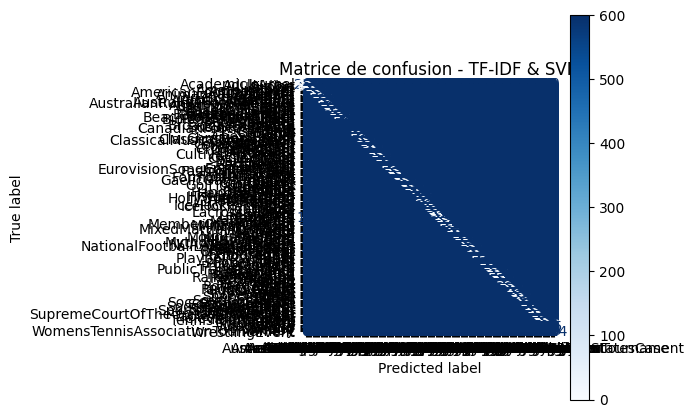

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Liste des modèles à évaluer
model_list = [
    ("TF-IDF & MNB", model_1, x_test, y_test),
    ("TF-IDF & SVM", model_2, x_test, y_test),
    # ("Word embedding & SVM", model_3, x_test_emb, y_test),
]

def evaluate(models):
    for name, model, x_test, y_test in models:
        print(f"\n===== Évaluation de {name} =====")
        
        # Affichage des meilleurs paramètres et du score si disponibles
        if hasattr(model, "best_params_"):
            print("Best parameters:", model.best_params_)
        if hasattr(model, "best_score_"):
            print("Best cross-validation score:", f"{model.best_score_:.4f}")

        # Évaluation sur le jeu de test
        try:
            test_score = model.score(x_test, y_test)
            print(f"Test accuracy: {test_score:.4f}")
            
            y_pred = model.predict(x_test)

            print("Classification Report:")
            print(classification_report(y_test, y_pred))

            # Affichage de la matrice de confusion
            cm = confusion_matrix(y_test, y_pred)
            labels = model.classes_ if hasattr(model, "classes_") else sorted(set(y_test))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Matrice de confusion - {name}")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Une erreur est survenue pendant l’évaluation de {name} : {e}")

    return None

# Appel
evaluate(model_list)


## Sauvegarder les modèles

In [ ]:
import joblib
joblib.dump(model_1, r'Model\Classification\Précis\model1.pkl')
joblib.dump(model_2, r'Model\Classification\Précis\model2.pkl')
joblib.dump(model_3, r'Model\Classification\Précis\model3.pkl')

['C:\\Users\\USER\\Desktop\\Master-1-Data-Science\\Traitement_du_language\\Projet\\Projet_code\\Model_new_dataset\\model3.pkl']